In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

from matplotlib.ticker import MultipleLocator

%matplotlib inline

In [5]:

df = pd.read_csv('per_minute.csv')

total_messages_per_minute = pd.DataFrame({
    'minute': df['minute'],
    'message_count': df['total']
})

member_messages_per_minute = pd.DataFrame({
    'minute': df['minute'],
    'message_count': df['member']
})


moving_average = pd.DataFrame({
    'minute': df['minute'],
    'message_count': df['mv10']
})


In [6]:
time_labels = pd.to_datetime(total_messages_per_minute['minute'], unit='m').dt.strftime('%H:%M')

time_labels_10min = time_labels[::10]
minutes_10min = total_messages_per_minute['minute'][::10]

In [7]:
mean_frequency = moving_average['message_count'].mean()
std_dev_frequency = moving_average['message_count'].std()

peak_threshold = mean_frequency + 1.96 * std_dev_frequency

peaks = total_messages_per_minute[total_messages_per_minute['message_count'] > peak_threshold].copy(True)
peaks['text_minute'] =  pd.to_datetime(peaks['minute'], unit='m').dt.strftime('%H:%M:%S')

peaks

,minute,message_count,text_minute
3,3,211,00:03:00
19,19,193,00:19:00
20,20,304,00:20:00
21,21,270,00:21:00
22,22,362,00:22:00
56,56,233,00:56:00
57,57,180,00:57:00
74,74,202,01:14:00
99,99,195,01:39:00
126,126,217,02:06:00


In [8]:
peak_start_end = pd.DataFrame({
    'minute': total_messages_per_minute['minute'],
    'chat_frequency': total_messages_per_minute['message_count'],
    'moving_average': moving_average['message_count']
})
peak_start_end['is_above_average'] = peak_start_end['chat_frequency'] > peak_start_end['moving_average']
# .shift() 將 is_above_average 欄位的數值往後移動一個位置，這樣可以比較當前的值和前一個值。
# .ne() 比較當前值和前一個值是否不同。如果不同，表示出現了趨勢的變化（從低於到高於，或從高於到低於）。
# .cumsum() 累積計數，為每個趨勢變化賦予一個唯一的組別號碼。這樣可以將每個連續的 True 或 False 區間歸類在一起。
peak_transitions = peak_start_end['is_above_average'].ne(peak_start_end['is_above_average'].shift()).cumsum()

# 對每個分組，檢查該區間內的所有值是否都為 True，也就是確定這段時間都處於峰值。如果是，則返回該區間的起點和終點（x.index.min() 和 x.index.max()）
start_end_times = peak_start_end.groupby(peak_transitions).apply(lambda x: (x.index.min(), x.index.max()) if x['is_above_average'].all() else None).dropna()

start_end_times.head()

is_above_average
2       (1, 1)
4       (3, 4)
6       (6, 7)
8       (9, 9)
10    (15, 16)
dtype: object

In [9]:
range_threashold = 3
merged_intervals = []
previous_start, previous_end = None, None

for start, end in start_end_times:
    if previous_start is None:
        # Initialize the first interval
        previous_start, previous_end = start, end
    elif start - previous_end <= range_threashold:
        # Merge the intervals if the gap is less than threashold
        previous_end = end
    else:
        # Save the previous interval and start a new one
        merged_intervals.append((previous_start, previous_end))
        previous_start, previous_end = start, end

# Append the last interval
if previous_start is not None:
    merged_intervals.append((previous_start, previous_end))

merged_intervals

[(np.int64(1), np.int64(9)),
 (np.int64(15), np.int64(22)),
 (np.int64(35), np.int64(39)),
 (np.int64(45), np.int64(50)),
 (np.int64(55), np.int64(57)),
 (np.int64(67), np.int64(68)),
 (np.int64(72), np.int64(75)),
 (np.int64(87), np.int64(87)),
 (np.int64(94), np.int64(100)),
 (np.int64(109), np.int64(134)),
 (np.int64(143), np.int64(154)),
 (np.int64(160), np.int64(171)),
 (np.int64(177), np.int64(186)),
 (np.int64(191), np.int64(192)),
 (np.int64(196), np.int64(198)),
 (np.int64(202), np.int64(203)),
 (np.int64(207), np.int64(212))]

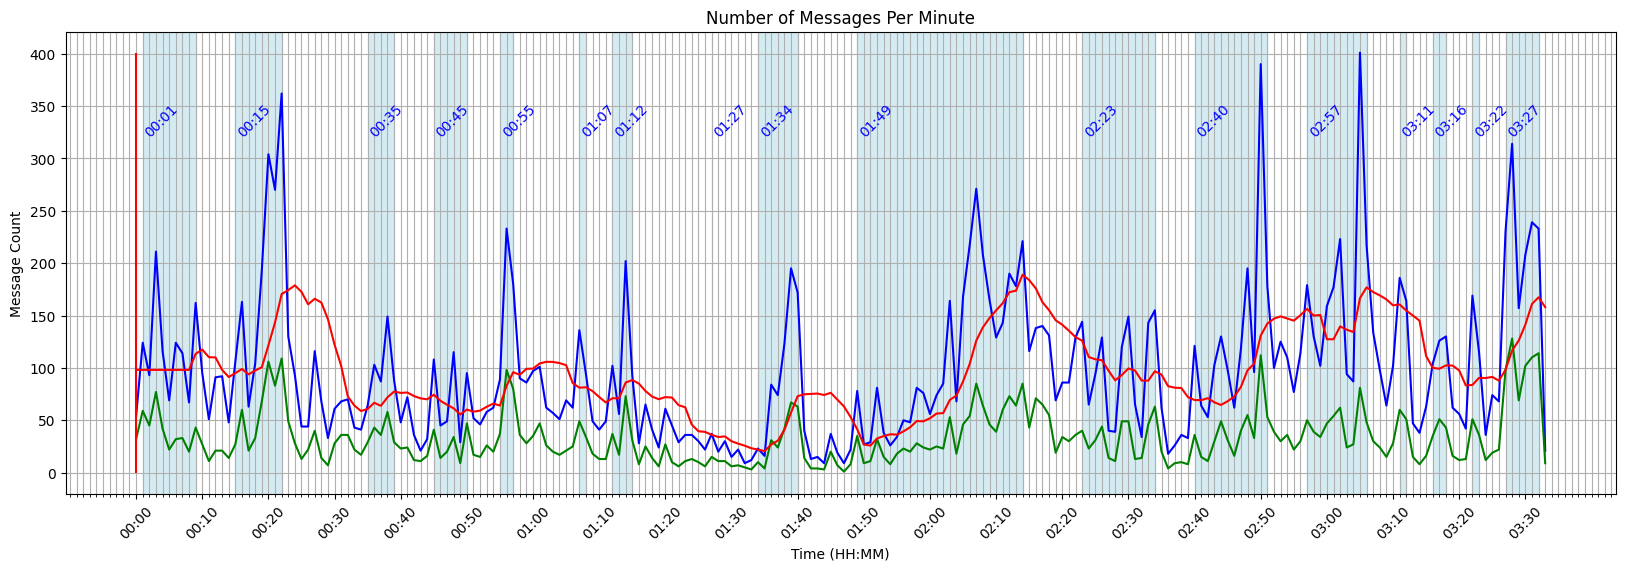

In [10]:
def minutes_to_hhmm(minutes):
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    return f'{hours:02d}:{mins:02d}'

plt.figure(figsize=(20, 6))

plt.plot(total_messages_per_minute['minute'], total_messages_per_minute['message_count'], label='Total Messages', color='blue')

plt.plot(member_messages_per_minute['minute'], member_messages_per_minute['message_count'], label='Member Messages', color='green')

plt.plot(moving_average['minute'], moving_average['message_count'], label="Moving Average", color='red')

for start, end in merged_intervals:
    plt.axvspan(start, end, color='lightblue', alpha=0.5)
    plt.text(start, total_messages_per_minute['message_count'].max() * 0.8, minutes_to_hhmm(start), color='blue', fontsize=10, rotation=45)

plt.vlines(0, ymin=0, ymax=total_messages_per_minute['message_count'].max(), colors='red')

plt.xticks(ticks=minutes_10min, labels=time_labels_10min, rotation=45)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel('Time (HH:MM)')
plt.ylabel('Message Count')
plt.title('Number of Messages Per Minute')

plt.grid(True, which='both')
plt.show()